<a href="https://colab.research.google.com/github/alok13/Machine-Learning/blob/master/Kaggle_Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import pandas as pd
import numpy as np

In [6]:
import os
os.environ['KAGGLE_USERNAME'] = "alok13" # username from the json file
os.environ['KAGGLE_KEY'] = "0a84636fc75d4a9f43d87644d220855d" # key from the json file
!kaggle competitions download -c digit-recognizer

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 52.0MB/s]
 55% 5.00M/9.16M [00:00<00:00, 21.3MB/s]
100% 9.16M/9.16M [00:00<00:00, 36.3MB/s]
 82% 5.00M/6.09M [00:00<00:00, 9.07MB/s]
100% 6.09M/6.09M [00:00<00:00, 10.4MB/s]


Files are downloaded in ZIP format.

In [0]:
# Helper function to download data and extract
import os
import zipfile
def get_data_extract(fileName):
  if fileName in os.listdir():
    print("Dataset already exists")
  else:
    print("Extracting data..")
    
    with zipfile.ZipFile(fileName+".zip", 'r') as zip_ref:
      zip_ref.extractall("")
    print("done!")

In [8]:
test=get_data_extract("test.csv")

Extracting data..
done!


In [9]:
train=get_data_extract("train.csv")

Extracting data..
done!


In [0]:
train_df=pd.read_csv("train.csv")

In [22]:
test_df=pd.read_csv("test.csv")
test_df.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
train_df[:0].values

array([], shape=(0, 785), dtype=int64)

In [13]:
test_df.shape

(42000, 785)

In [0]:
def imagify(tensor):
    reshaped = tensor.reshape(-1, 28, 28)
    print(reshaped.shape)
    reshaped = np.stack((reshaped,) *3, axis = 1)
    print(reshaped.shape)
    image_arr = []

    for idx, current_image in enumerate(reshaped):
        img = torch.tensor(current_image, dtype=torch.float) / 255.
        img = vision.image.Image(img)
        image_arr.append(img)
    return image_arr

In [16]:
labels = train_df.iloc[:,0].values.flatten()
images = imagify(train_df.iloc[:,1:].values)

(42000, 28, 28)
(42000, 3, 28, 28)


In [0]:
def split_data(data, labels, pct=0.8):
    train_xl = []
    train_yl = []
    valid_xl = []
    valid_yl = []

    for img, label in zip(data, labels):
        if random.random() >= pct:
            valid_xl.append(img)
            valid_yl.append(label)
        else:
            train_xl.append(img)
            train_yl.append(label)
    
    return train_xl, train_yl, valid_xl, valid_yl

In [0]:
train_xl, train_yl, valid_xl, valid_yl = split_data(images, labels, 0.8)

In [0]:
class TensorImageList(ImageList):
    def get(self, i):
        img = self.items[i]
        self.sizes[i] = img.size
        return img

In [23]:
test_xl = imagify(test_df.values)
test_xl = TensorImageList(test_xl)

(28000, 28, 28)
(28000, 3, 28, 28)


In [0]:
def create_label_lists(train_xl, train_yl, valid_xl, valid_yl):
    train_xl = TensorImageList(train_xl)
    train_yl = CategoryList(train_yl, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    valid_xl = TensorImageList(valid_xl)
    valid_yl = CategoryList(valid_yl, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    
    train_ll = LabelList(train_xl, train_yl)
    valid_ll = LabelList(valid_xl, valid_yl)
    
    return LabelLists(Path('.'), train_ll, valid_ll)

In [0]:
lls = create_label_lists(train_xl, train_yl, valid_xl, valid_yl)

In [0]:
tfms = get_transforms(do_flip=False)
mnist_data = ImageDataBunch.create_from_ll(lls, ds_tfms=tfms)
mnist_data.add_test(test_xl)

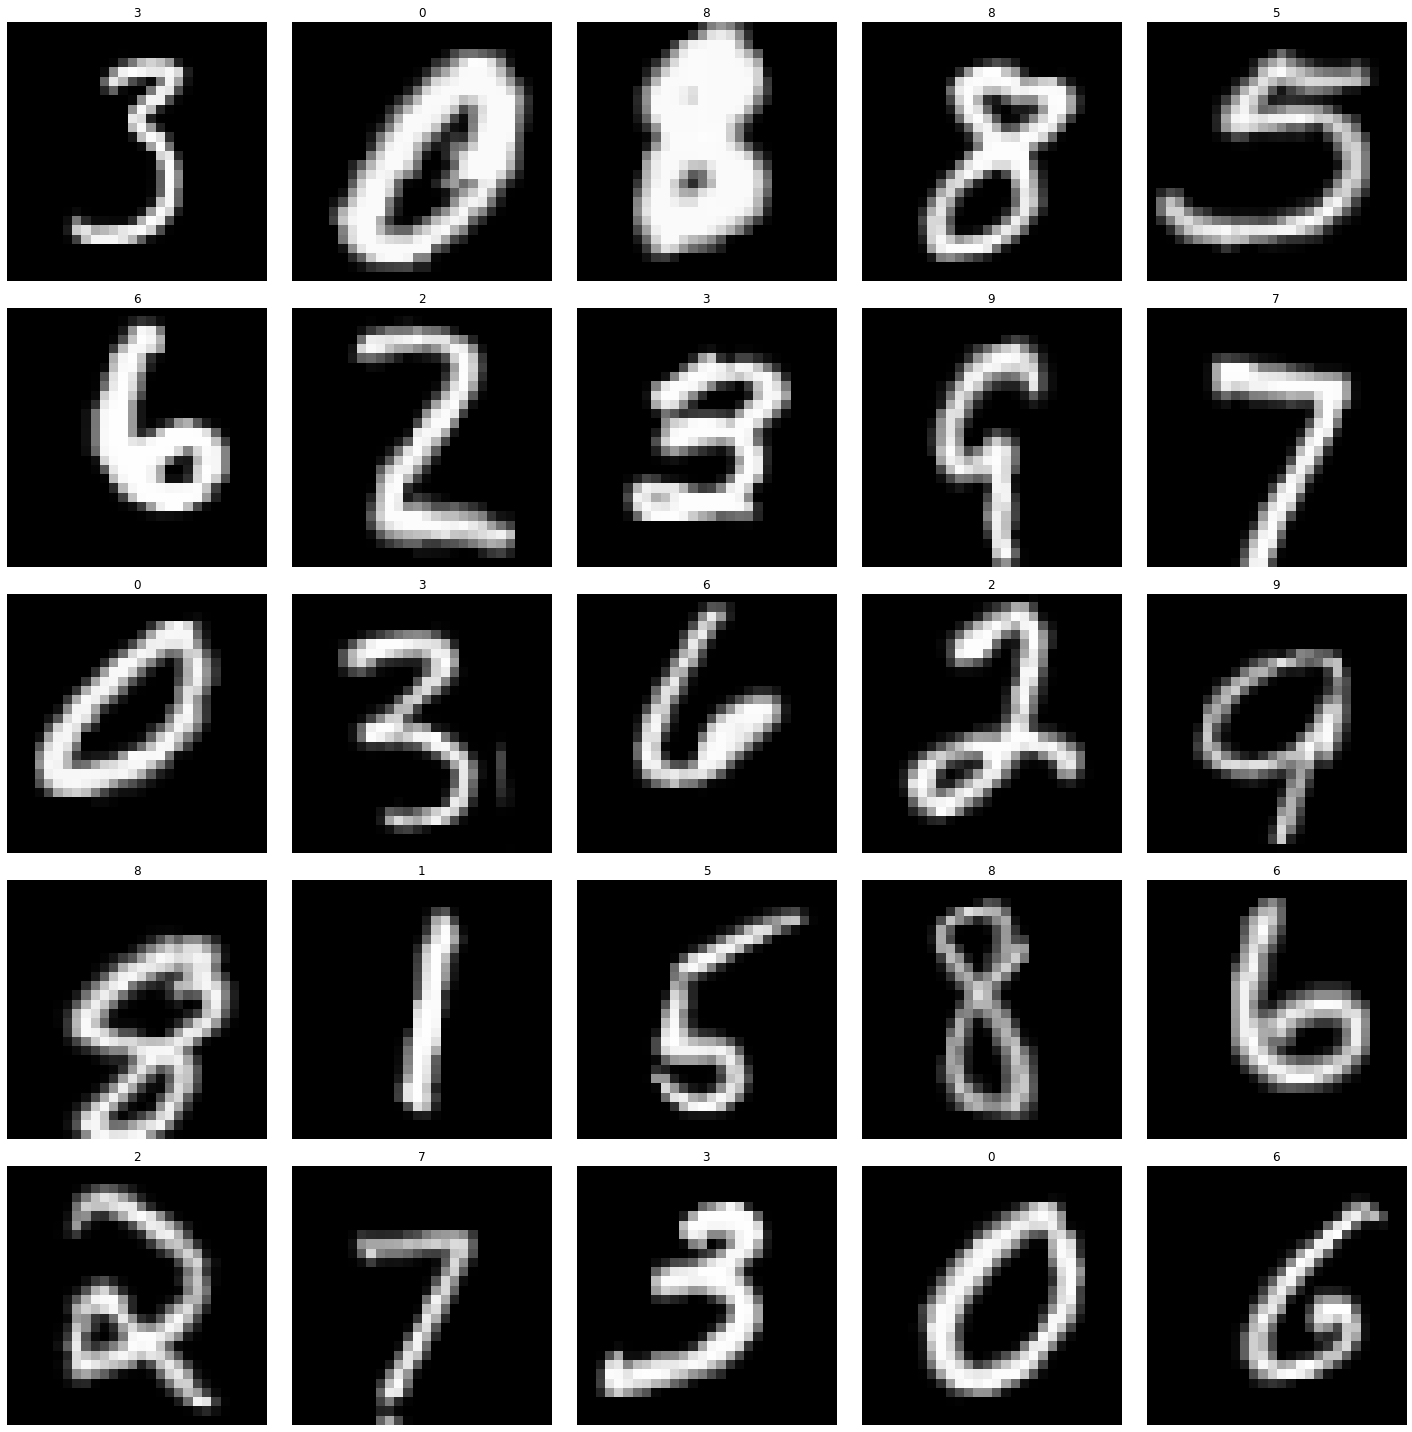

In [29]:
mnist_data.show_batch()

In [30]:
arch = models.resnet50 
learner = cnn_learner(mnist_data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 52.3MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


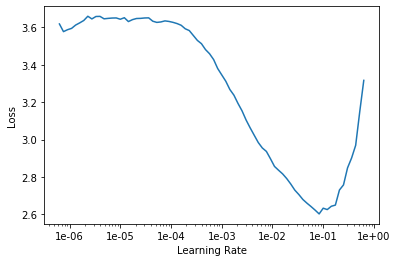

In [31]:
learner.lr_find()
learner.recorder.plot()

In [32]:
learner.fit_one_cycle(10, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.983490,0.725400,0.765866,00:53
1,0.472161,0.371648,0.881080,00:52
2,0.269090,0.156718,0.951357,00:52
3,0.158829,0.091243,0.969404,00:51
4,0.139492,0.070966,0.975738,00:52
5,0.106668,0.063033,0.977172,00:51
6,0.084671,0.097596,0.981236,00:51
7,0.077099,0.041797,0.985538,00:51
8,0.061527,0.042594,0.984821,00:51
9,0.058985,0.037808,0.986495,00:51


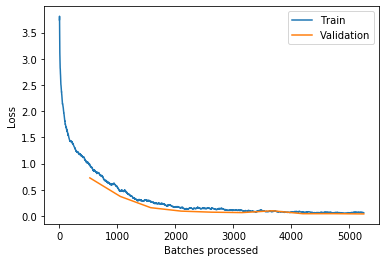

In [33]:
learner.recorder.plot_losses()

In [0]:
learner.save('mnist-1') 

In [36]:
learner.unfreeze()
learner.fit_one_cycle(10, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.065116,0.036230,0.987331,00:59
1,0.065593,0.035352,0.988407,00:58
2,0.054891,0.035320,0.987570,00:57
3,0.054336,0.034375,0.989363,00:57
4,0.047959,0.032507,0.988407,00:57
5,0.041942,0.032104,0.989841,00:57
6,0.048385,0.029055,0.989602,00:57
7,0.047406,0.032786,0.989602,00:57
8,0.037624,0.028846,0.990319,00:57
9,0.038820,0.028972,0.989363,00:57


In [0]:
learner.save('mnist-2')

In [38]:
preds = learner.get_preds(ds_type=DatasetType.Test)

In [41]:
preds[0]

tensor([[1.2281e-08, 1.5477e-08, 1.0000e+00,  ..., 3.4340e-08, 2.3383e-07,
         5.6643e-09],
        [9.9998e-01, 5.3158e-07, 1.4167e-07,  ..., 9.0241e-08, 5.8771e-06,
         5.9805e-06],
        [3.5342e-05, 4.1088e-06, 1.1996e-04,  ..., 2.0833e-04, 2.0301e-04,
         9.9917e-01],
        ...,
        [3.1602e-11, 1.0644e-09, 5.0872e-08,  ..., 9.6511e-10, 1.4280e-08,
         1.0401e-10],
        [5.5130e-06, 1.3781e-07, 5.2359e-08,  ..., 1.6748e-06, 4.0326e-06,
         9.9994e-01],
        [1.5772e-08, 1.8453e-09, 1.0000e+00,  ..., 2.9313e-09, 6.4963e-07,
         4.6303e-09]])

In [0]:
pred_values = preds[0].argmax(1).numpy()

In [43]:
submission = DataFrame({'ImageId': list(range(1, len(pred_values) + 1)), 'Label': pred_values})
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [0]:
submission.to_csv('digitsResult.csv', index=False)